# Fully Convolutional Network (FCN)

In [1]:
import _models_utils
import _tiles_utils
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [2]:
# Carga de datos y configuración de parámetros de entrenamiento
num_epochs = 20
batch_size = 16
img_width = 256
input_dimensions = (256, 256, 4)
shuffle_data = True
use_augmentation = False  # {True, False} para controlar si se utiliza augmentación

# Definimos los parámetros de augmentación si están habilitados
if use_augmentation:
    augmentation_params = {
        "flip_left_right": 0,
        "flip_up_down": 0,
        "gaussian_blur": 0.2,
        "random_noise": 0.0,
        "random_brightness": 0.5,
        "random_contrast": 0.5
    }
else:
    augmentation_params = None  # No se utiliza augmentación

# Cargamos los datasets de entrenamiento, validación y prueba
train_data, val_data, test_data = _models_utils.load_datasets(use_augmentation=use_augmentation)


In [3]:
def build_fcn_model(input_dimensions):
    """
    Construye un modelo Fully Convolutional Network (FCN) para segmentación de imágenes.

    Parámetros:
    -----------
    input_dimensions : tuple
        Dimensiones de entrada de las imágenes (altura, ancho, canales).

    Retorna:
    --------
    tf.keras.Model
        El modelo FCN compilado.
    """
    inputs = Input(shape=input_dimensions)
    
    # Codificación (Encoding)
    conv_block_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv_block_1 = BatchNormalization()(conv_block_1)
    conv_block_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_block_1)
    conv_block_1 = BatchNormalization()(conv_block_1)
    pooling_1 = MaxPooling2D(pool_size=(2, 2))(conv_block_1)
    
    conv_block_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pooling_1)
    conv_block_2 = BatchNormalization()(conv_block_2)
    conv_block_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_block_2)
    conv_block_2 = BatchNormalization()(conv_block_2)
    pooling_2 = MaxPooling2D(pool_size=(2, 2))(conv_block_2)
    
    conv_block_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pooling_2)
    conv_block_3 = BatchNormalization()(conv_block_3)
    conv_block_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_block_3)
    conv_block_3 = BatchNormalization()(conv_block_3)
    pooling_3 = MaxPooling2D(pool_size=(2, 2))(conv_block_3)
    
    conv_block_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pooling_3)
    conv_block_4 = BatchNormalization()(conv_block_4)
    conv_block_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_block_4)
    conv_block_4 = BatchNormalization()(conv_block_4)
    pooling_4 = MaxPooling2D(pool_size=(2, 2))(conv_block_4)
    
    # Cuello de botella (Bottleneck)
    conv_block_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pooling_4)
    conv_block_5 = BatchNormalization()(conv_block_5)
    conv_block_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_block_5)
    conv_block_5 = BatchNormalization()(conv_block_5)
    
    # Decodificación (Decoding)
    upsample_block_6 = UpSampling2D(size=(2, 2))(conv_block_5)
    upsample_block_6 = Conv2D(256, (2, 2), activation='relu', padding='same')(upsample_block_6)
    upsample_block_6 = BatchNormalization()(upsample_block_6)
    merge_6 = Concatenate(axis=-1)([upsample_block_6, conv_block_4])
    conv_block_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge_6)
    conv_block_6 = BatchNormalization()(conv_block_6)
    conv_block_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_block_6)
    conv_block_6 = BatchNormalization()(conv_block_6)
    
    upsample_block_7 = UpSampling2D(size=(2, 2))(conv_block_6)
    upsample_block_7 = Conv2D(128, (2, 2), activation='relu', padding='same')(upsample_block_7)
    upsample_block_7 = BatchNormalization()(upsample_block_7)
    merge_7 = Concatenate(axis=-1)([upsample_block_7, conv_block_3])
    conv_block_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge_7)
    conv_block_7 = BatchNormalization()(conv_block_7)
    conv_block_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_block_7)
    conv_block_7 = BatchNormalization()(conv_block_7)
    
    upsample_block_8 = UpSampling2D(size=(2, 2))(conv_block_7)
    upsample_block_8 = Conv2D(64, (2, 2), activation='relu', padding='same')(upsample_block_8)
    upsample_block_8 = BatchNormalization()(upsample_block_8)
    merge_8 = Concatenate(axis=-1)([upsample_block_8, conv_block_2])
    conv_block_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge_8)
    conv_block_8 = BatchNormalization()(conv_block_8)
    conv_block_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_block_8)
    conv_block_8 = BatchNormalization()(conv_block_8)
    
    upsample_block_9 = UpSampling2D(size=(2, 2))(conv_block_8)
    upsample_block_9 = Conv2D(32, (2, 2), activation='relu', padding='same')(upsample_block_9)
    upsample_block_9 = BatchNormalization()(upsample_block_9)
    merge_9 = Concatenate(axis=-1)([upsample_block_9, conv_block_1])
    conv_block_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge_9)
    conv_block_9 = BatchNormalization()(conv_block_9)
    conv_block_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_block_9)
    conv_block_9 = BatchNormalization()(conv_block_9)
    
    # Capa de salida
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv_block_9)
    
    # Creamos el modelo
    model = Model(inputs=[inputs], outputs=[output_layer])
    
    return model



In [4]:
# Creamos el modelo con las dimensiones de entrada especificadas
fcn_model = build_fcn_model(input_dimensions)
fcn_model.summary()  # Mostramos el resumen del modelo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
# ----------- Crear directorios para guardar resultados, pesos y predicciones
output_directory = '../results/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_FCN/'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    os.makedirs(os.path.join(output_directory, 'plots'))
    os.makedirs(os.path.join(output_directory, 'weights'))
    os.makedirs(os.path.join(output_directory, 'predictions'))
    os.makedirs(os.path.join(output_directory, 'bestweights'))

# Definir la ruta donde se guardarán los mejores pesos del modelo
checkpoint_path = os.path.join(output_directory, 'bestweights', 'model.{epoch:02d}-{val_loss:.4f}.weights.h5')

# Definir el callback para guardar los mejores pesos durante el entrenamiento
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Guardamos solo los pesos del modelo
    save_best_only=True,  # Guardamos solo los mejores pesos
    monitor='val_accuracy',  # Monitorizamos la precisión en validación
    mode='max',  # Buscamos el valor máximo de 'val_accuracy'
    verbose=1  # Mostramos información durante el guardado
)

# Compilar el modelo con el optimizador Adam y la función de pérdida binaria
fcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

# Entrenamos el modelo con los datasets de entrenamiento y validación, usando el callback para guardar pesos
history = fcn_model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=num_epochs, 
    callbacks=[checkpoint_callback]
)


Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9419
Epoch 1: val_accuracy improved from -inf to 0.82638, saving model to ../results/2024-11-11_11-51-05_FCN/bestweights\model.01-0.6375.weights.h5
125/125 [==============================] - 61s 402ms/step - loss: 0.1453 - accuracy: 0.9419 - val_loss: 0.6375 - val_accuracy: 0.8264
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9624
Epoch 2: val_accuracy improved from 0.82638 to 0.97643, saving model to ../results/2024-11-11_11-51-05_FCN/bestweights\model.02-0.0609.weights.h5
125/125 [==============================] - 43s 347ms/step - loss: 0.0983 - accuracy: 0.9624 - val_loss: 0.0609 - val_accuracy: 0.9764
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9676
Epoch 3: val_accuracy improved from 0.97643 to 0.97823, saving model to ../results/2024-11-11_11-51-05_FCN/bestweights\model.03-0.0579.weights.h5
125/125 [

In [6]:
import glob

# Buscar todos los archivos de pesos en la carpeta 'bestweights'
weights_files = glob.glob(os.path.join(output_directory, 'bestweights', '*.weights.h5'))

if weights_files:
    # Seleccionar el archivo más reciente basado en la fecha de creación
    most_recent_weights = max(weights_files, key=os.path.getctime)
    print(f"Cargando los pesos más recientes desde: {most_recent_weights}")
    
    # Cargar los pesos en el modelo
    fcn_model.load_weights(most_recent_weights)
else:
    # Mostrar un mensaje si no se encuentran archivos de pesos
    print("No se encontraron archivos de pesos en el directorio 'bestweights'.")


Cargando los pesos más recientes desde: ../results/2024-11-11_11-51-05_FCN/bestweights\model.05-0.0521.weights.h5


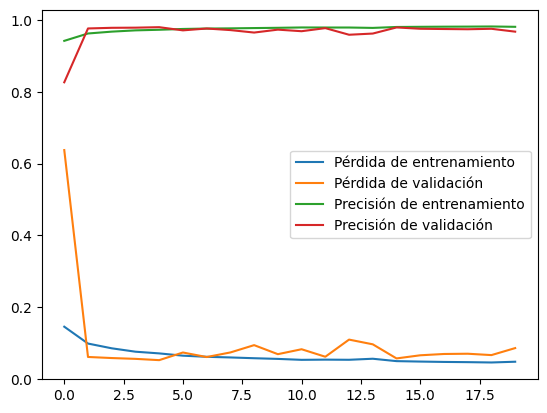

In [7]:
from tensorflow.keras.optimizers import Adam

# Compilar el modelo con el optimizador Adam y la función de pérdida binaria
fcn_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=["accuracy"])

# Guardar los pesos del modelo final
fcn_model.save_weights(os.path.join(output_directory, 'model.weights.h5'))

# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.savefig(os.path.join(output_directory, 'plots', 'loss.png'))

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.savefig(os.path.join(output_directory, 'plots', 'accuracy.png'))

# Guardar el modelo final
fcn_model.save(os.path.join(output_directory, 'weights', 'final_model.h5'))



1/1 [==============================] - 1s 1s/step


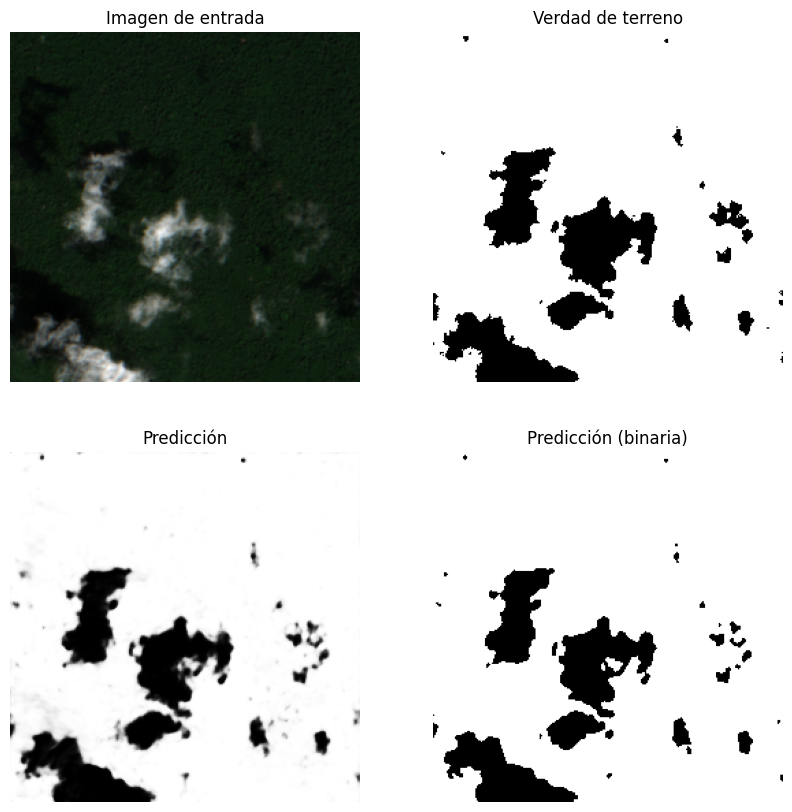

1/1 [==============================] - 0s 26ms/step


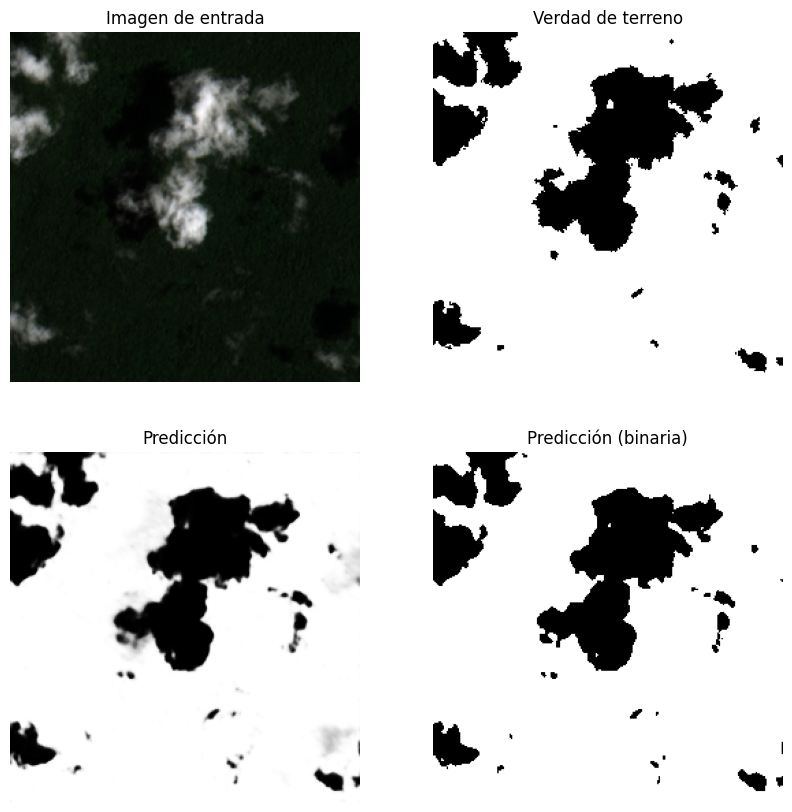

1/1 [==============================] - 0s 28ms/step


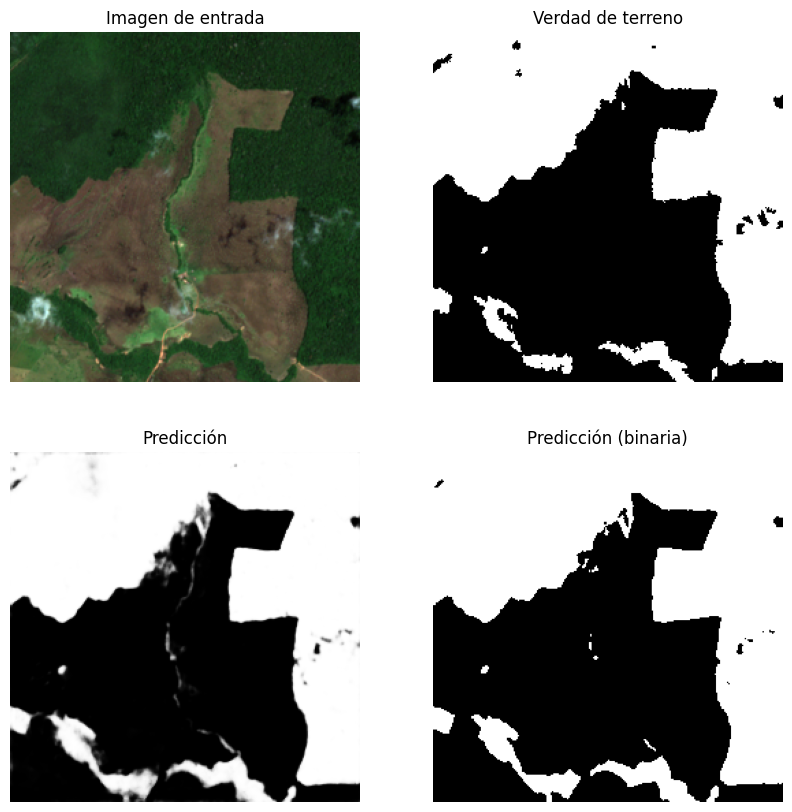

1/1 [==============================] - 0s 24ms/step


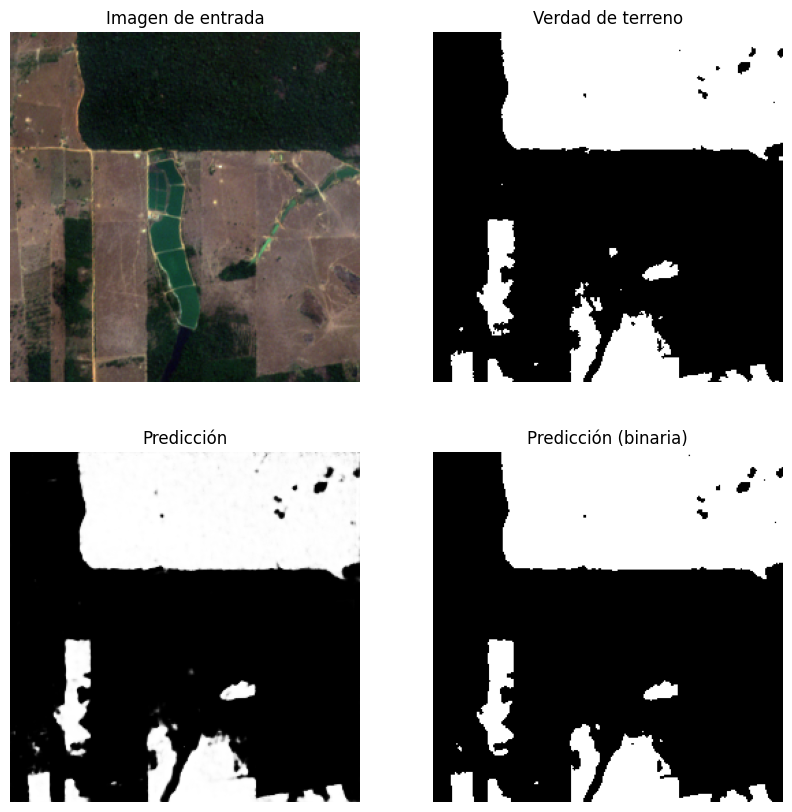

1/1 [==============================] - 0s 26ms/step


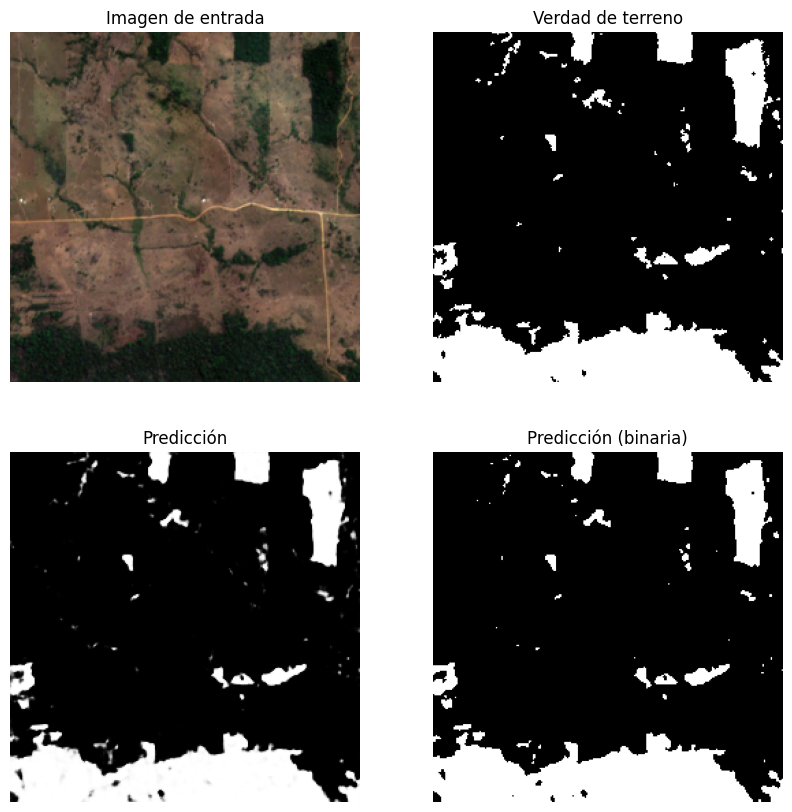

1/1 [==============================] - 0s 30ms/step


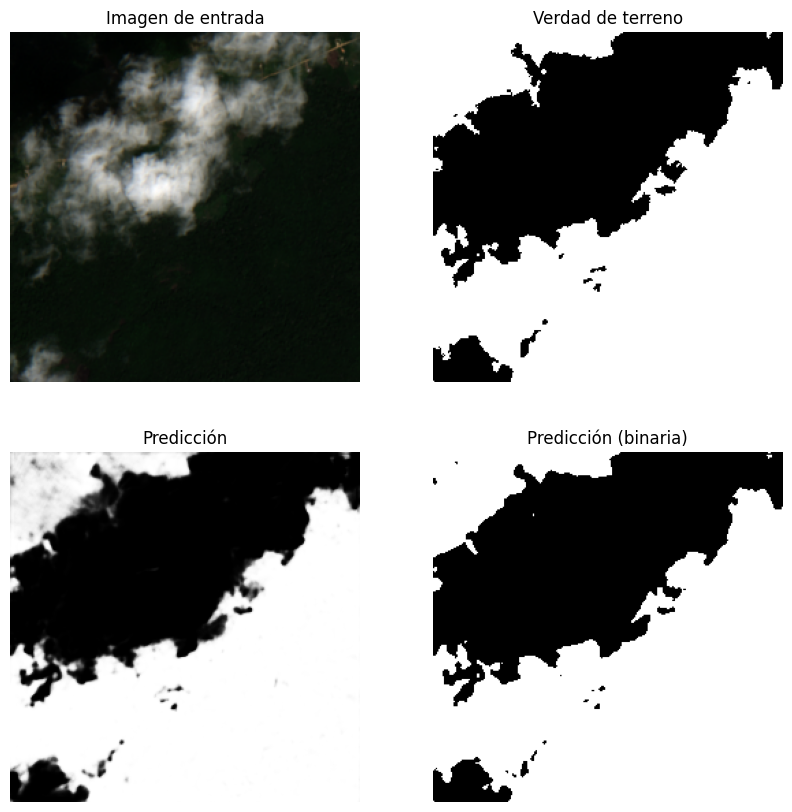

1/1 [==============================] - 0s 28ms/step


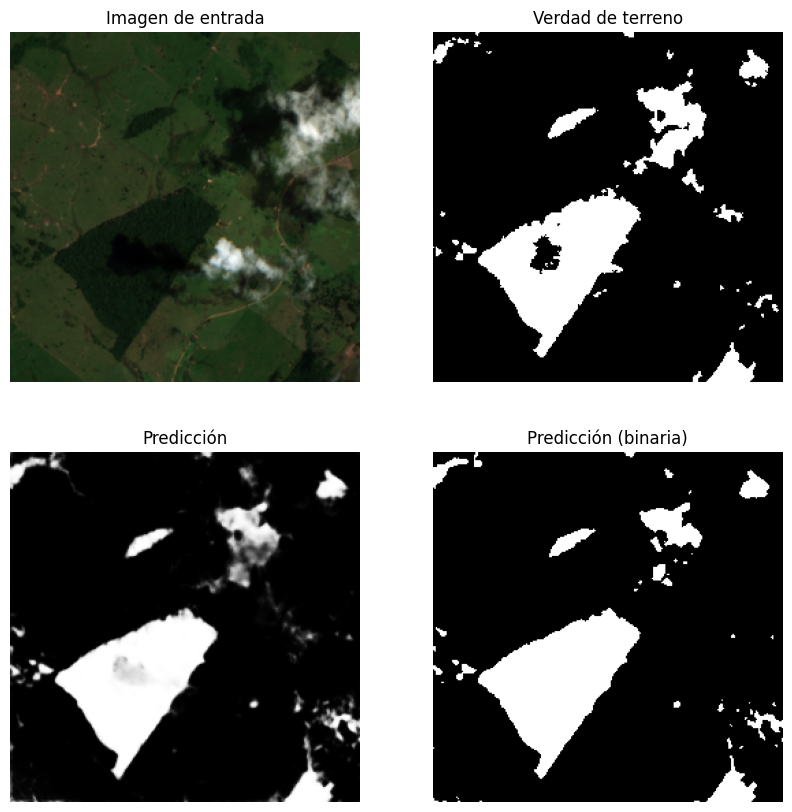

1/1 [==============================] - 0s 35ms/step


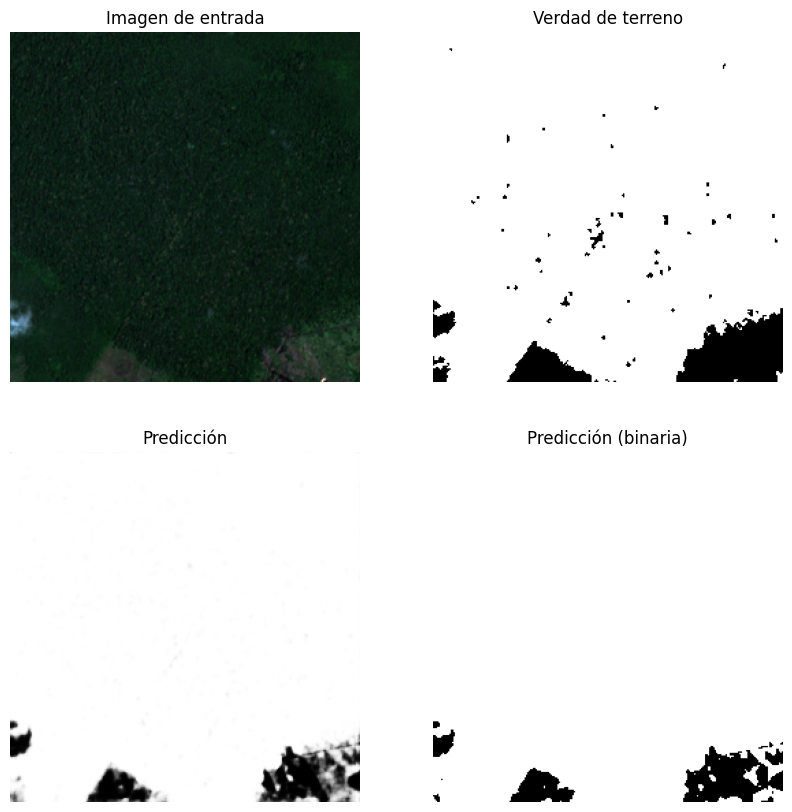

1/1 [==============================] - 0s 25ms/step


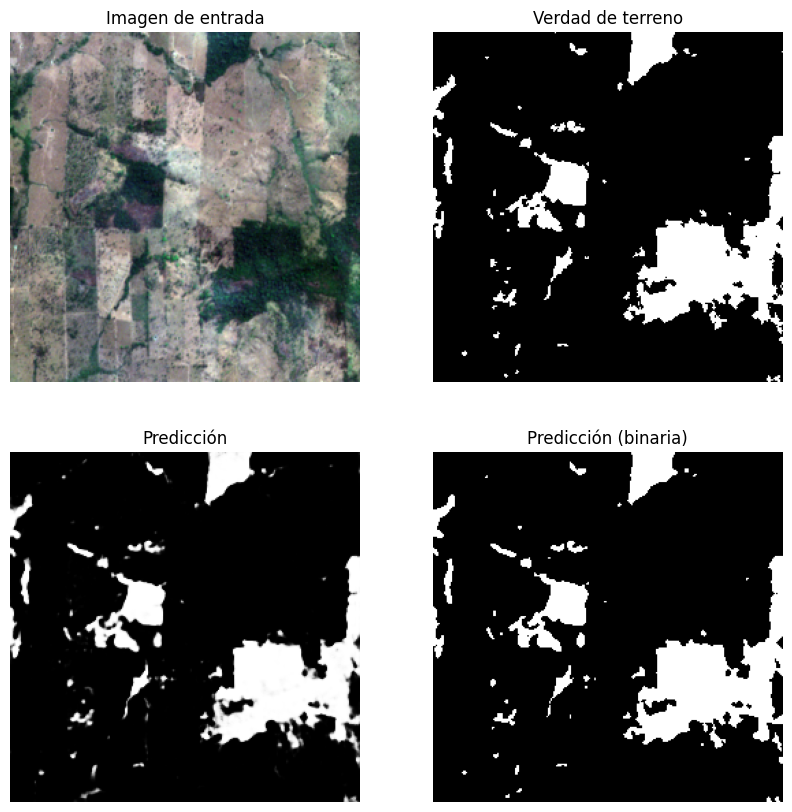

1/1 [==============================] - 0s 24ms/step


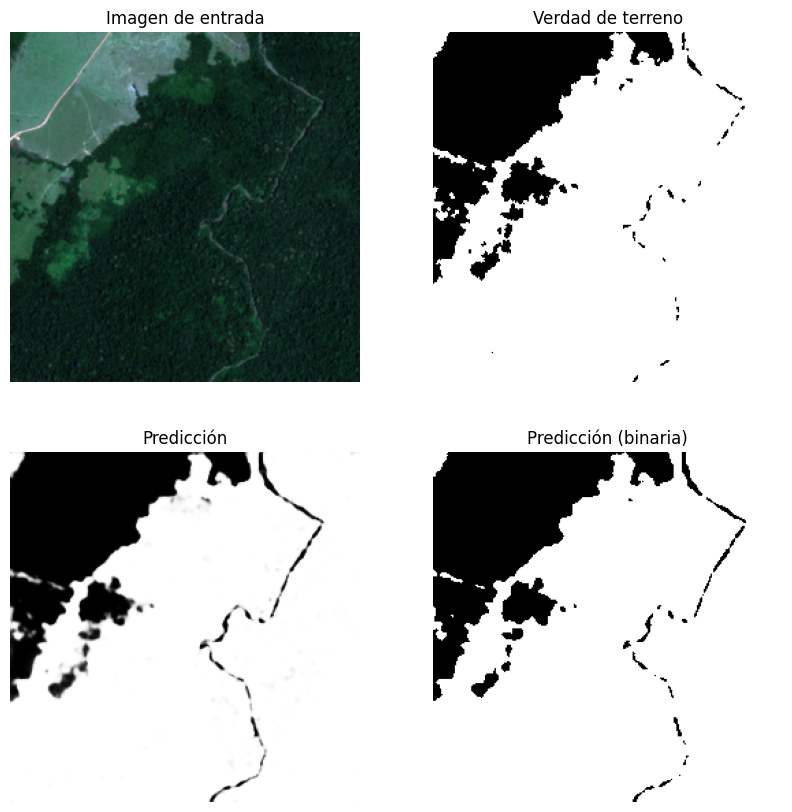

In [8]:
# Generar y guardar predicciones para los primeros 80 ejemplos del dataset de prueba

for i in range(10):
    _models_utils.save_and_visualize_predictions_fcn(i, fcn_model, test_data, output_directory, batch_size, True)

In [9]:
# ----------- Guardar métricas
model_metrics = _models_utils.evaluate_model(
    "FCN", 
    test_data, 
    fcn_model, 
    input_dimensions, 
    shuffle_data, 
    batch_size, 
    num_epochs, 
    augment_settings=augmentation_params, 
    threshold=0.5)

# Guardar las métricas en un archivo CSV
metrics_df = pd.DataFrame(model_metrics)
metrics_df.to_csv(os.path.join(output_directory, 'metrics.csv'), index=False)

1/1 [==============================] - 0s 30ms/step
